In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({'font.size':18}) # Use for all plots
# run installed version of flopy or add local path

import flopy

#try:
#    import flopy
#except:
#    fpth = os.path.abspath(os.path.join("..", ".."))
#    sys.path.append(fpth)
#    import flopy

RL: create data directory if not already there, then define string for workspace directory.

In [33]:
%%sh
mkdir -p ./data/Base_case

In [37]:
workspace = "./data/Base_case"

In [39]:
name = "Base_case_clay"
length_units = "Meter"
time_units = "DAYS"

nper = 1
Nlay = 10
nrows = 5
ncol = 50
delr = 1
delc = 1
ss = 1e-5
sy = 0.15 
thts = 0.3  # Saturated water content (unitless)
thti = 0.1  # Initial water content (unitless)
thtr = 0.1  # Base residual water content (unitless)
eps = 3.5
uzf_kv = 1e-6
surf_dep=0.00010

vk = 0.5 #m/day
top = 10
hk = 1.0 #m/day
H = 10
L = 50

h_k = hk * np.ones((Nlay,nrows,ncol))
hk33 = vk * np.ones((Nlay, nrows, ncol))

tdis_ds = [(1.0, 1, 1.0)]



In [40]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=r".\mf6", 
    version="mf6", sim_ws=workspace
)
# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=tdis_ds,
)


# Create the Flopy groundwater flow (gwf) model object
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file, newtonoptions="newton")

# Create the discretization package
bot = np.linspace(-H / Nlay+top, -H+top, Nlay)
delrow = delr
delcol = delc
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=Nlay,
    nrow=nrows,
    ncol=ncol,
    delr=delrow,
    delc=delcol,
    top=top,
    botm=bot,
    length_units = "METERS"
)


flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=1,
    sy=sy,
    ss=ss,
    steady_state={0:True}
)
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=h_k, k33=hk33, save_flows=True, save_saturation=True, save_specific_discharge=True,
)


# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", linear_acceleration="BICGSTAB")


In [41]:


#uzf = flopy.mf6.ModflowGwfuzf(
#    gwf,
#    pname="UZF-1",
#    nuzfcells=nuzfcells,
#    ntrailwaves=7,
#    nwavesets=40,
#    packagedata=packagedata,
#    perioddata=uzf_perioddata,
#)

In [42]:
# Create the initial conditions package
h1 = 15 
start = h1 * np.ones((Nlay, nrows, ncol))
start[0,:,0] = 2.5
start[0,:,-1] = 1.5
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)

In [43]:
chd_rec = []
for i in range(Nlay):
    for j in range(nrows):
        chd_rec.append(((i, j, 0), 20))
        chd_rec.append(((i, j, 49), 15))

chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)


In [44]:
# Create the output control package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [45]:
sim.write_simulation(silent=True)

In [46]:
success, buff = sim.run_simulation()
print("\nSuccess is: ", success)

FloPy is using the following executable to run the model: .\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 30 2021 14:34:58 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software Use

RL: replaced use of `os` package with the directory name as a string (no need to specify root).

In [49]:
#case1 get heads
fname = workspace + "/" + headfile
hds = flopy.utils.binaryfile.HeadFile(fname)

Heads_case1 = [(hds.get_data(kstpkper=(0, 0)))]

h0 = hds.get_data(kstpkper=(0, 0))


RL: Check directory names:

In [50]:
print(fname)
print(headfile)
print(hds)

./data/Base_case/Base_case_clay.hds
Base_case_clay.hds


In [51]:
# Get Watertables for two cases
WT_case1_row3 =[]

for i in range(len(Heads_case1)):
    WT_case1 = flopy.utils.postprocessing.get_water_table(Heads_case1[i], nodata=False)
    WT_case1_row3.append(WT_case1[0])
   


RL: remove `os` here also (first line):

In [60]:
bfname = workspace + "/" + budgetfile
cbcdobj = flopy.utils.binaryfile.CellBudgetFile(bfname, precision="double")
#SPDIS = cbcdobj.get_data(kstpkper=(0,0), text='DATA-SPDIS')[0] # node, node, 1, qx, qy, qz
SAT= cbcdobj.get_data(kstpkper=(0,0), text='DATA-SAT')[0] #output: node, node, q, saturation

In [61]:
def plot_water_table(wt, row=1):
    x = np.linspace(0+0.5*delc, L-0.5*delc, ncol)
    for i in range(len(wt)):
        plt.plot(x, wt[i], lw=4)
        

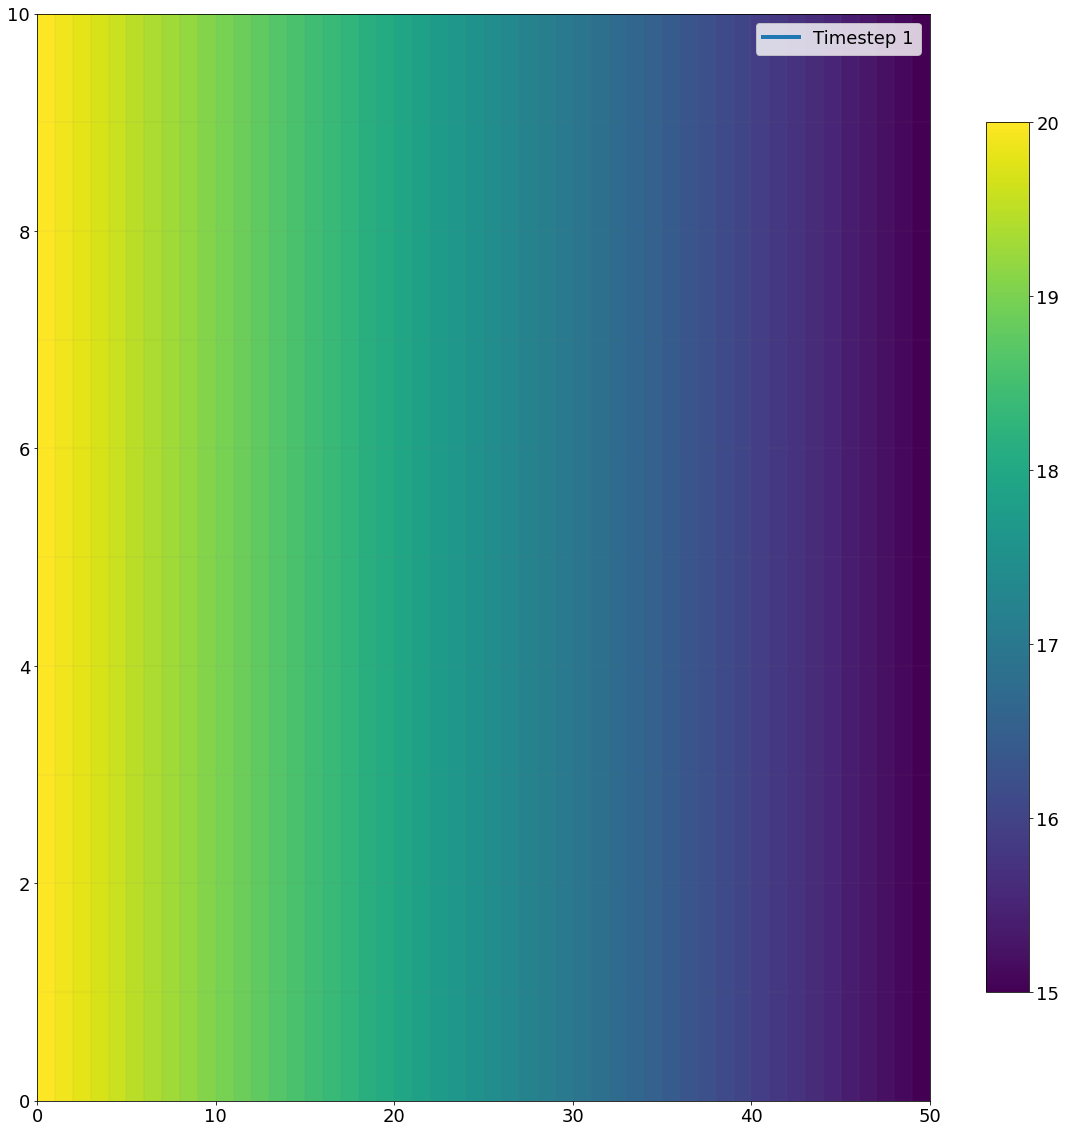

In [62]:
#Plot cross-section 
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
cros_mp=flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={'row': 0})  
pa = cros_mp.plot_array(Heads_case1[0])

linecollection = cros_mp.plot_grid(lw=0.05, color="0.5")

cb = plt.colorbar(pa, shrink=0.8, ax=ax)

plot_water_table(wt=WT_case1_row3)
plt.legend(['Timestep 1', 'Timestep 2', 'Timestep 3', 'Timestep 4', 'Timestep 5'])


In [63]:
#Calculate difference in WT
#np.subtract(WT_case1_row3, WT_case2_row3)

In [64]:
bfname = os.path.join(workspace, budgetfile)
cbcdobj = flopy.utils.binaryfile.CellBudgetFile(bfname, precision='double', verbose=False )
SPDIS = cbcdobj.get_data(kstpkper=(0,0), text='DATA-SPDIS')[0] # node, node, 1, qx, qy, qz
SAT= cbcdobj.get_data(kstpkper=(0,0), text='DATA-SAT')[0] #output: node, node, q, saturation

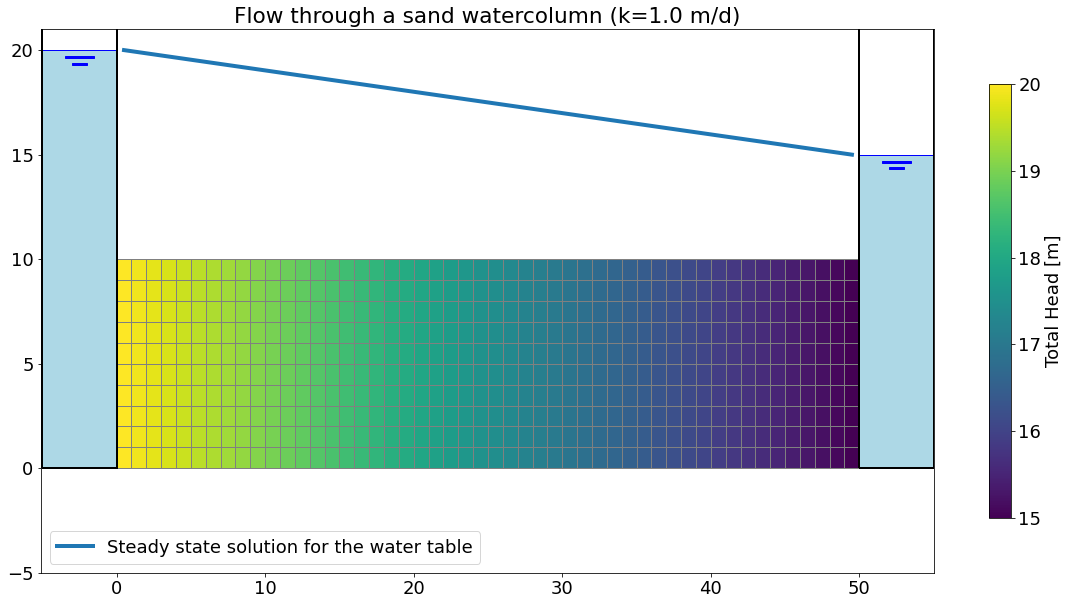

In [65]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
cros_mp=flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={'row': 1})  
pa = cros_mp.plot_array(Heads_case1[0])

linecollection = cros_mp.plot_grid(lw=1, color="0.5")

cb = plt.colorbar(pa, shrink=0.8, ax=ax, label="Total Head [m]")
plot_water_table(wt=WT_case1_row3)
plt.legend(['Steady state solution for the water table'])
ax.set_ylim([-5, 21])
ax.set_xlim([-5.1, 55])

rect = Rectangle((-5, 0), 5, 20, linewidth=1, edgecolor='blue', facecolor='lightblue')
rect_3 = Rectangle((-5, 0), 5, 25, linewidth=2, edgecolor='black', facecolor='none')
rect_2 = Rectangle((50, 0), 5, 15, linewidth=1, edgecolor='blue', facecolor='lightblue')
rect_4 = Rectangle((50, 0), 5, 25, linewidth=2, edgecolor='black', facecolor='none')
wt_1 = Rectangle((-3.5, 19.6), 2, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_2 = Rectangle((-3, 19.3), 1, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_3 = Rectangle((51.5, 14.6), 2, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_4 = Rectangle((52, 14.3), 1, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
ax.add_patch(rect)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(wt_1)
ax.add_patch(wt_2)
ax.add_patch(wt_3)
ax.add_patch(wt_4)
ax.set_title("Flow through a sand watercolumn (k=1.0 m/d)");

C:\Users\rlanzafame\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:1036: DeprecationWarning: plot_specific_discharge() has been deprecated and will beremoved in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  DeprecationWarning,


Text(0.5, 1.0, 'Specific discharge')

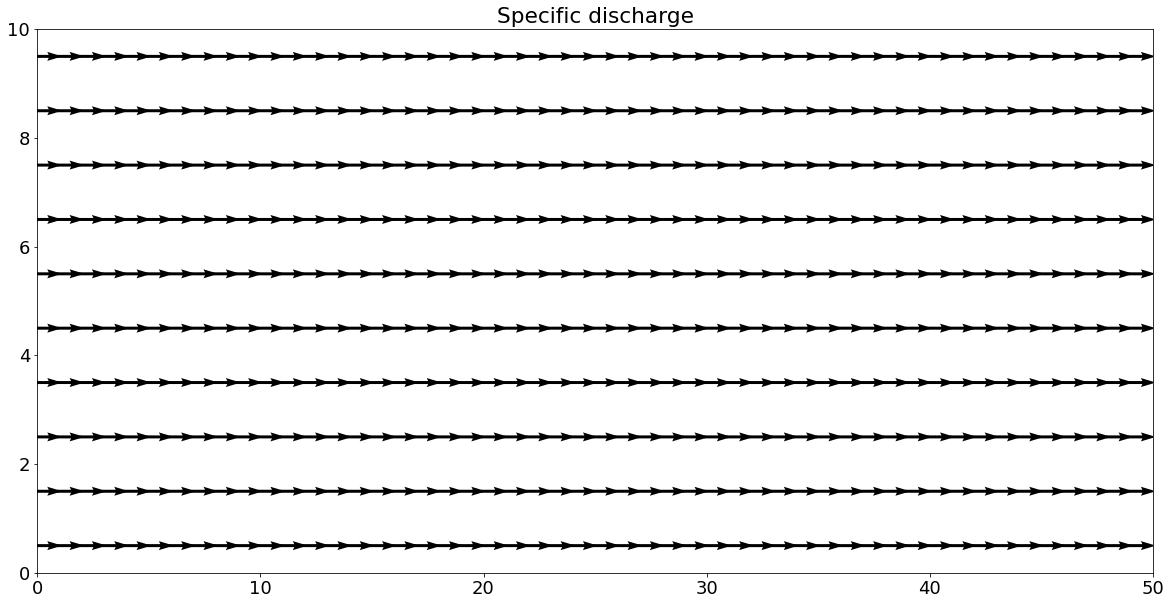

In [58]:
#Plot cross-section 
SPDIS = cbcdobj.get_data(kstpkper=(0,0), text='DATA-SPDIS')[0] # node, node, 1, qx, qy, qz
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
cros_mp=flopy.plot.PlotCrossSection(model=gwf, line={'row': 1})  
cros_mp.plot_specific_discharge(SPDIS)
ax.set_title('Specific discharge')